In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab
from matplotlib.ticker import MaxNLocator, FixedLocator
import seaborn as sns
from scipy.stats import skew as skew

from numba import jit, cuda, njit, prange
from timeit import default_timer as timer

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 10
sgm = 5
threshold = 70
#S = 576
R_initial = 35

In [3]:
@njit(parallel=True, fastmath=True)
def ratio_choice(r, a, b):

    alpha = a
    beta = b

    S = (w11+w12-beta) * R_initial**2 + (1-alpha) * R_initial
    V1 = 2 * S * r
    V2 = 2 * S - V1

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    R1_arr[0], R2_arr[0] = R_initial, R_initial
    # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
    # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = (w11+w12-beta)*R1_arr[0], (w22+w21-beta)*R2_arr[0]

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = beta*R1_arr[0], beta*R2_arr[0]

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in range(10240):

        for ti in prange(1, int(dur/dt)):
            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold:
                choice[i] = 1
                reaction_time[i] = ti
                break
            elif R2_arr[ti] > threshold:
                reaction_time[i] = ti
                break
            elif ti == dur/dt:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice

In [4]:
@njit
def heatmap_array():
    alpha_arr, beta_arr = np.arange(0.5, 80, 0.5), np.arange(0.1, 2.5, 0.1)
    #alpha_arr, beta_arr = np.arange(0.5, 80, 5), np.arange(0.1, 2.5, 0.1)
    RT_arr, choice_arr = np.zeros((len(beta_arr), len(alpha_arr), 10240)), np.zeros((len(beta_arr), len(alpha_arr), 10240))

    for column, alpha in enumerate(alpha_arr):
        for row, beta in enumerate(beta_arr):
            RT_arr[row, column, :], choice_arr[row, column, :] = ratio_choice(.5640, alpha, beta)

    # column = 0
    # for alpha in alpha_arr:
    #     row = 0
    #     for beta in beta_arr:
    #         RT_arr[row, column, :], choice_arr[row, column, :] = ratio_choice(.5640, alpha, beta)
    #         row += 1
    #     column += 1

        #print("\r[ALPHA]: %i" % alpha, end='')

    return RT_arr, choice_arr

In [5]:
RT_arr, choice_arr = heatmap_array()

In [5]:
def heatmap_val(RT, choice):
    alpha_arr, beta_arr = np.arange(0.5, 80, 0.5), np.arange(0.1, 2.5, 0.1)
    #alpha_arr, beta_arr = np.arange(0.5, 80, 5), np.arange(0.1, 2.5, 0.1)
    RT_skew, RT_mean = np.zeros((len(beta_arr), len(alpha_arr))), np.zeros((len(beta_arr), len(alpha_arr)))
    RT_std, choice_acc = np.zeros((len(beta_arr), len(alpha_arr))), np.zeros((len(beta_arr), len(alpha_arr)))

    for column in range(len(alpha_arr)):
        for row in range(len(beta_arr)):
            curr_reaction, curr_choice = RT[row, column, :], choice[row, column, :]
            RT_skew[row, column], RT_mean[row, column], RT_std[row, column] = skew(curr_reaction), np.mean(curr_reaction), np.std(curr_reaction)
            choice_acc[row, column] = np.nanmean(curr_choice)

    return RT_skew, RT_mean, RT_std, choice_acc

In [6]:
@jit
def get_heatmap(RT_skew, RT_mean, RT_std, choice_acc):
    #alpha_arr, beta_arr = np.arange(0.5, 80, 0.5), np.arange(0.1, 2.5, 0.1)
    alpha_arr, beta_arr = np.arange(0.5, 80, 5), np.arange(0.1, 2.5, 0.1)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    skew_ax = sns.heatmap(RT_skew, ax=axes[0, 0])
    skew_ax.set_title("Skewness")
    mean_ax = sns.heatmap(RT_mean, ax=axes[0, 1])
    mean_ax.set_title("Mean")
    std_ax = sns.heatmap(RT_std, ax=axes[1, 0])
    std_ax.set_title("STD")
    choice_ax = sns.heatmap(choice_acc, ax=axes[1,1])
    choice_ax.set_title("Choice Accuracy")

    for ax in axes.flat:
        ax.set_xlabel("alpha", fontsize=12)
        ax.set_ylabel("beta", fontsize=12)

        x_tick_labels = alpha_arr[::int(len(alpha_arr) / 15)]
        ax.xaxis.set_major_locator(MaxNLocator(len(x_tick_labels)))
        x_ticks = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(FixedLocator(x_ticks))
        ax.set_xticklabels(np.concatenate((x_tick_labels, [x_tick_labels[0]])), rotation=45)

    # ax3.xaxis.set_major_locator(mticker.MaxNLocator(3))
    # ticks_loc = ax3.get_xticks().tolist()
    # ax3.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    # ax3.set_xticklabels([label_format.format(x) for x in ticks_loc])

        y_tick_labels = beta_arr[::int(len(beta_arr) / 9)]
        ax.yaxis.set_major_locator(MaxNLocator(len(y_tick_labels)))
        # y_ticks = ax.get_yticks().tolist()
        # #ax.set_yticklabels(y_ticks, rotation=45)
        # ax.yaxis.set_major_locator(FixedLocator(y_ticks))
        # y_tick_labels = np.concatenate((y_tick_labels, [y_tick_labels[0]]))
        ax.set_yticklabels([i.round(2) for i in y_tick_labels])
        #ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

C:\Users\weiyi\AppData\Local\Temp\ipykernel_23332\3551972154.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  get_heatmap(RT_skew, RT_mean, RT_std, choice_acc)


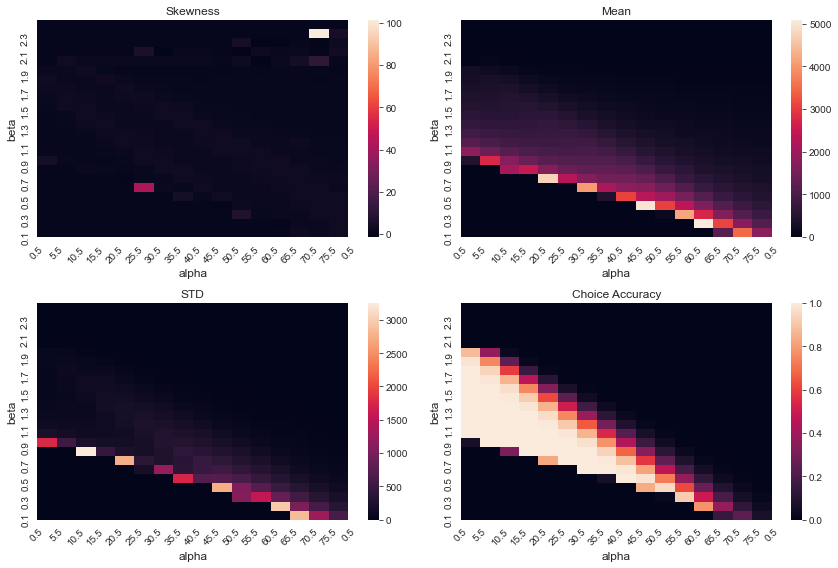

In [44]:
RT_skew, RT_mean, RT_std, choice_acc = heatmap_val(RT_arr, choice_arr)
get_heatmap(RT_skew, RT_mean, RT_std, choice_acc)
np.savetxt('skew.csv', RT_skew, delimiter=",")
np.savetxt('std.csv', RT_std, delimiter=",")
np.savetxt('mean.csv', RT_mean, delimiter=",")
np.savetxt('choice.csv', choice_acc, delimiter=",")
np.save('choice.npy', choice_arr)

In [33]:
s = timer()
RT_skew, RT_mean, RT_std, choice_acc = get_heatmap()
t = timer()-s

C:\Users\weiyi\AppData\Local\Temp\ipykernel_15044\2515456400.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_heatmap" failed type inference due to: Untyped global name 'skew': Cannot determine Numba type of <class 'function'>

File "..\AppData\Local\Temp\ipykernel_15044\2515456400.py", line 12:
<source missing, REPL/exec in use?>

  @jit
C:\Users\weiyi\AppData\Local\Temp\ipykernel_15044\2515456400.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_heatmap" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\AppData\Local\Temp\ipykernel_15044\2515456400.py", line 8:
<source missing, REPL/exec in use?>

  @jit
C:\Users\weiyi\anaconda3\envs\LDDM\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "get_heatmap" was compiled in object mode without forceobj=True, but has lifted lo

SystemError: CPUDispatcher(<function ratio_choice at 0x0000020E4331EF70>) returned a result with an error set

In [ ]:
alpha_arr, beta_arr = np.arange(0.5, 80, 0.5), np.arange(0.1, 2.5, 0.1)
#alpha_arr, beta_arr = np.arange(1, 20, 1), np.arange(0.1, 1.5, 0.1)
RT_skew, RT_mean = np.zeros((len(beta_arr), len(alpha_arr))), np.zeros((len(beta_arr), len(alpha_arr)))
RT_std, choice_acc = np.zeros((len(beta_arr), len(alpha_arr))), np.zeros((len(beta_arr), len(alpha_arr)))
column = 0
for alpha in alpha_arr:
    row = 0
    for beta in beta_arr:
        print("\r[ALPHA]: %f [BETA]: %f" % (alpha, beta), end='')
        curr_reaction, curr_choice = ratio_choice(.5640, alpha, beta)
        RT_skew[row, column], RT_mean[row, column], RT_std[row, column] = skew(curr_reaction), np.mean(curr_reaction), np.std(curr_reaction)
        choice_acc[row, column] = np.nanmean(curr_choice)
        row += 1
    column += 1

[ALPHA]: 10.000000 [BETA]: 0.500000

In [6]:
alpha1, alpha2, alpha3 = 15, 20, 25
beta1, beta2, beta3= 1.1, 1.4, 1.7

In [7]:
a2_b1_reaction_time, a2_b1_choice = ratio_choice(.5640, alpha2, beta1)
a2_b2_reaction_time, a2_b2_choice = ratio_choice(.5640, alpha2, beta2)
a2_b3_reaction_time, a2_b3_choice = ratio_choice(.5640, alpha2, beta3)

a1_b2_reaction_time, a1_b2_choice = ratio_choice(.5640, alpha1, beta2)
a3_b2_reaction_time, a3_b2_choice = ratio_choice(.5640, alpha3, beta2)

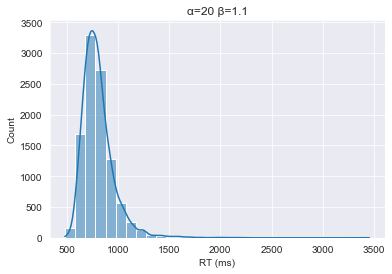

2.8364338684273154


In [55]:
sns.histplot(a2_b1_reaction_time, bins=30, kde=True)
plt.title("α=20 β=1.1")
plt.xlabel("RT (ms)")
plt.show()
print(skew(a2_b1_reaction_time))

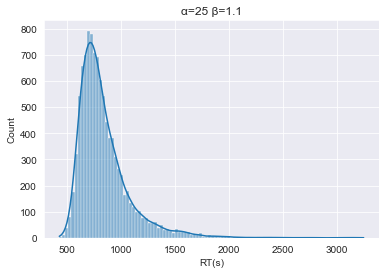

2.306863869447905


In [45]:
sns.histplot(a2_b1_reaction_time, bins=100, kde=True)
plt.title("α=25 β=1.1")
plt.xlabel("RT(s)")
plt.show()
print(skew(a2_b1_reaction_time))

In [25]:
df2 = pd.DataFrame(
    {
        "α=15 β=0.9": a2_b1_reaction_time,
    }
)

In [ ]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

sns.histplot(data=df, x="sepal_length", color="skyblue", label="Sepal Length", kde=True)
sns.histplot(data=df, x="sepal_width", color="red", label="Sepal Width", kde=True)

plt.legend()
plt.show()

In [19]:
df = pd.DataFrame(
    {
        "α=20 β=1.1": a2_b1_reaction_time,
        "α=20 β=1.4": a2_b2_reaction_time,
        "α=20 β=1.7": a2_b3_reaction_time,
        "α=15 β=1.4": a1_b2_reaction_time,
        "α=25 β=1.4": a3_b2_reaction_time,
    }
)

In [22]:
print(max(a2_b1_reaction_time)-min(a2_b1_reaction_time))

2214.0


In [100]:
def draw_hist(df, arr_name, ax, color):
    # diff = max(df[arr_name]) - min(df[arr_name])
    # bins = np.arange(min(arr), max(arr), 50)
    # count, bin_edges = np.histogram(arr, bins=bins)
    # norm = max(count)
    # count = count / norm

    bins = np.arange(df[arr_name].min(), df[arr_name].max(), 50)
    count, bin_edges = np.histogram(df[arr_name].to_numpy(), bins=bins)
    norm = max(count)
    count = count / norm

    new_df = pd.DataFrame(bin_edges[:-1], columns=[arr_name])

    #ax_arg.hist(bin_edges[:-1], bins=bins, weights=count)
    sns.histplot(data=new_df, x=arr_name, bins=bins, weights=count, color=color, label=color, kde=True, ax=ax)


C:\Users\weiyi\anaconda3\envs\LDDM\lib\site-packages\seaborn\distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
C:\Users\weiyi\anaconda3\envs\LDDM\lib\site-packages\seaborn\distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
C:\Users\weiyi\anaconda3\envs\LDDM\lib\site-packages\seaborn\distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


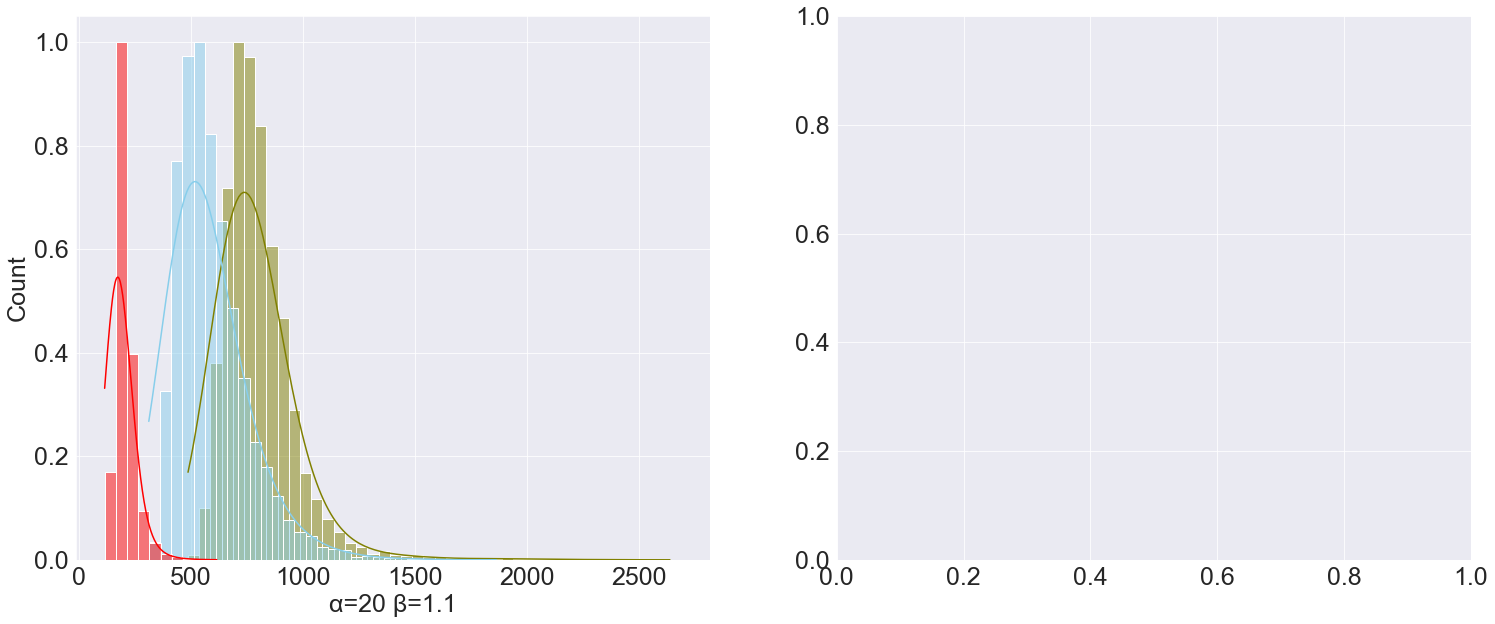

In [103]:
fig, (same_alpha, same_beta) = plt.subplots(1, 2, figsize=(25, 10))
draw_hist(df, "α=20 β=1.1", same_alpha, 'olive')
draw_hist(df, "α=20 β=1.4", same_alpha, 'skyblue')
draw_hist(df, "α=20 β=1.7", same_alpha, 'red')
#
# draw_hist(a1_b2_reaction_time, same_beta)
# draw_hist(a2_b2_reaction_time, same_beta)
# draw_hist(a3_b2_reaction_time, same_beta)

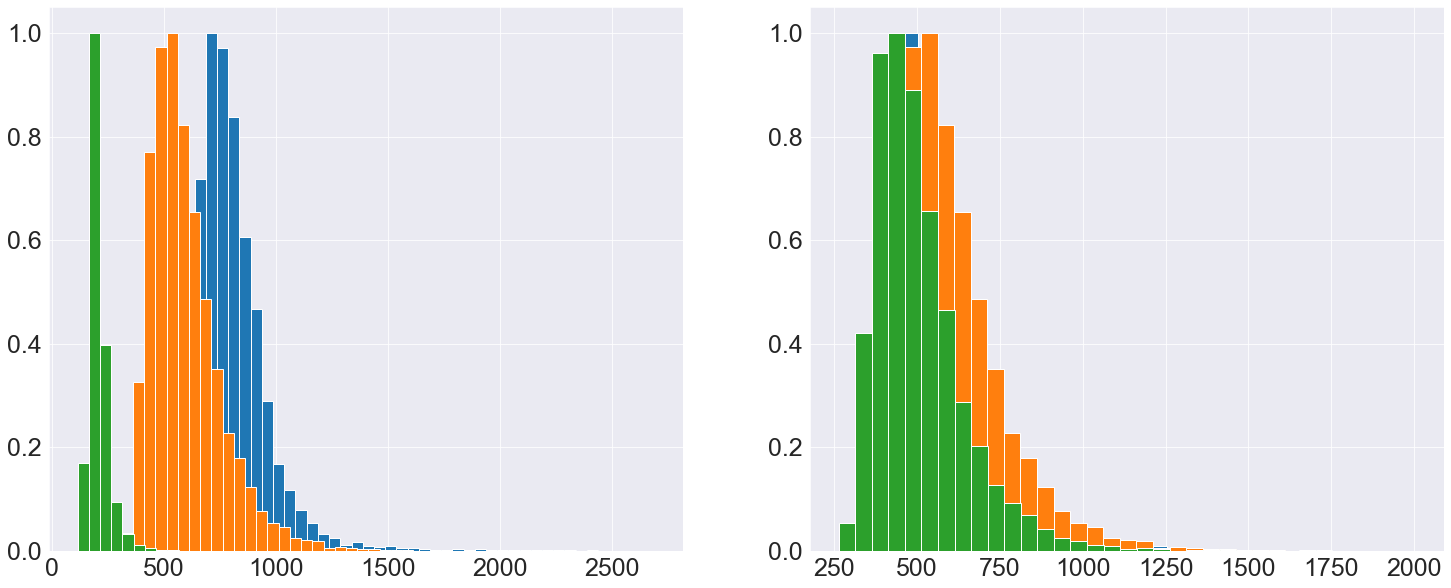

In [92]:
fig, (same_alpha, same_beta) = plt.subplots(1, 2, figsize=(25, 10))
draw_hist(a2_b1_reaction_time, same_alpha)
draw_hist(a2_b2_reaction_time, same_alpha)
draw_hist(a2_b3_reaction_time, same_alpha)

draw_hist(a1_b2_reaction_time, same_beta)
draw_hist(a2_b2_reaction_time, same_beta)
draw_hist(a3_b2_reaction_time, same_beta)

(array([9.86651190e-03, 9.92455020e-02, 3.79570517e-01, 7.17353453e-01,
        1.00000000e+00, 9.72141613e-01, 8.38653511e-01, 6.07080673e-01,
        4.67788741e-01, 2.89030760e-01, 1.68311085e-01, 1.18398143e-01,
        7.83517121e-02, 5.45560070e-02, 3.30818340e-02, 2.43760882e-02,
        1.04468950e-02, 1.62507255e-02, 9.86651190e-03, 6.96459663e-03,
        8.70574579e-03, 4.64306442e-03, 4.64306442e-03, 2.90191526e-03,
        1.74114916e-03, 1.16076611e-03, 3.48229832e-03, 1.74114916e-03,
        3.48229832e-03, 1.16076611e-03, 1.74114916e-03, 1.74114916e-03,
        1.16076611e-03, 5.80383053e-04, 5.80383053e-04, 5.80383053e-04,
        5.80383053e-04, 0.00000000e+00, 5.80383053e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 487.,  537.,  587.,  637.,  687.,  737.,  787.,  837.,  887.,
         937.,  987., 1037., 1087., 1137., 1187., 1237., 1287., 1337.,
        1387., 1437., 1487., 1537., 1587., 1637., 1687., 1737., 

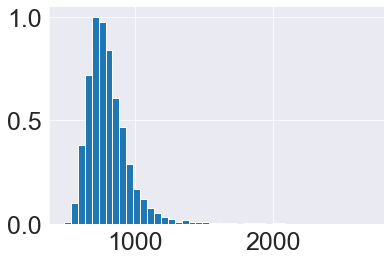

In [64]:
plt.hist(j[:-1], weights=k, bins=b)

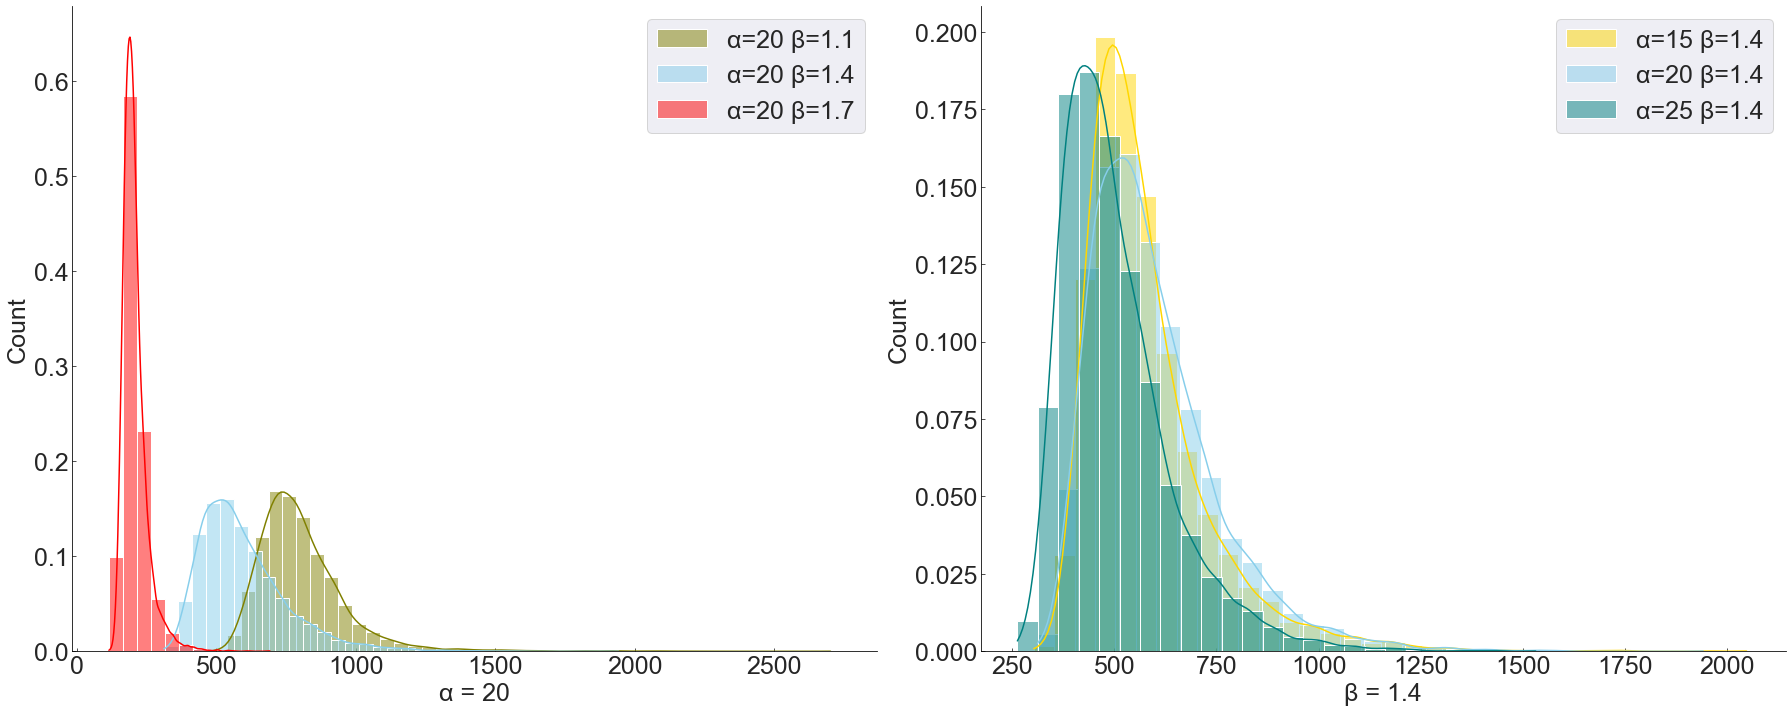

In [18]:
fig, (same_alpha, same_beta) = plt.subplots(1, 2, figsize=(25, 10))



bin_width = 50

sns.histplot(data=df, x="α=20 β=1.1", binwidth=bin_width, weights=np.ones_like(df["α=20 β=1.1"])/df["α=20 β=1.1"].size, color="olive", label="α=20 β=1.1", kde=True, ax=same_alpha)
sns.histplot(data=df, x="α=20 β=1.4", binwidth=bin_width, weights=np.ones_like(df["α=20 β=1.4"])/df["α=20 β=1.4"].size, color="skyblue", label="α=20 β=1.4", kde=True, ax=same_alpha)
sns.histplot(data=df, x="α=20 β=1.7", binwidth=bin_width, weights=np.ones_like(df["α=20 β=1.7"])/df["α=20 β=1.7"].size, color="red", label="α=20 β=1.7", kde=True, ax=same_alpha)

sns.histplot(data=df, x="α=15 β=1.4", binwidth=bin_width, weights=np.ones_like(df["α=15 β=1.4"])/df["α=15 β=1.4"].size, color="gold", label="α=15 β=1.4", kde=True, ax=same_beta)
sns.histplot(data=df, x="α=20 β=1.4", binwidth=bin_width, weights=np.ones_like(df["α=20 β=1.4"])/df["α=20 β=1.4"].size, color="skyblue", label="α=20 β=1.4", kde=True, ax=same_beta)
sns.histplot(data=df, x="α=25 β=1.4", binwidth=bin_width, weights=np.ones_like(df["α=25 β=1.4"])/df["α=25 β=1.4"].size, color="teal", label="α=25 β=1.4", kde=True, ax=same_beta)

# sns.histplot(data=df, x="α=20 β=1.1", binwidth=bin_width, color="olive", label="α=20 β=1.1", kde=True, ax=same_alpha)
# sns.histplot(data=df, x="α=20 β=1.4", binwidth=bin_width, color="skyblue", label="α=20 β=1.4", kde=True, ax=same_alpha)
# sns.histplot(data=df, x="α=20 β=1.7", binwidth=bin_width, color="red", label="α=20 β=1.7", kde=True, ax=same_alpha)
#
# sns.histplot(data=df, x="α=15 β=1.4", binwidth=bin_width, color="gold", label="α=15 β=1.4", kde=True, ax=same_beta)
# sns.histplot(data=df, x="α=20 β=1.4", binwidth=bin_width, color="skyblue", label="α=20 β=1.4", kde=True, ax=same_beta)
# sns.histplot(data=df, x="α=25 β=1.4", binwidth=bin_width, color="teal", label="α=25 β=1.4", kde=True, ax=same_beta)

same_alpha.set_xlabel("α = 20")
same_beta.set_xlabel("β = 1.4")

for ax in (same_alpha, same_beta):

    plt.grid(False)
    ax.tick_params(axis='x', direction="in")
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(bottom=True, left=True)
    ax.spines['bottom'].set_color('0')
    ax.spines['left'].set_color('0')
    ax.patch.set_facecolor('white')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    font_size = 25
    params = {
             'legend.fontsize': font_size,
             'axes.labelsize': font_size,
             'axes.titlesize': font_size,
             'xtick.labelsize': font_size,
             'ytick.labelsize': font_size}
    pylab.rcParams.update(params)
    ax.legend()

plt.tight_layout()
plt.savefig("histogram.tiff", format="tiff")
#plt.show()